In [1]:
#!pip3 install statsmodels
# !pip3 uninstall statsmodels -y
!pip3 install pmdarima

from IPython.display import clear_output
from pmdarima.arima import auto_arima
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import math

clear_output()

In [2]:
# connect to google drive
in_colab = False
try:
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir("/content/drive/My Drive/Capstone/Project_1")  
    in_colab = True
except:
    pass

Mounted at /content/drive


In [3]:
# Load Data

gdp_df = pd.read_excel("Data/GDP_quarterly_data.xlsx")
gdp_df = gdp_df.drop(['Unnamed: 0'], axis =1)

cpi_df = pd.read_excel("Data/CPI_Monthly_Change.xlsx")
cpi_df = cpi_df.drop(['Unnamed: 0'], axis =1)

cpi_df = cpi_df[1:].reset_index(drop=True) # drop first row - doesn't have a previous month to calculate change

In [45]:
gdp_df.head()

,Year,Gross domestic product,Personal consumption expenditures,Goods,Durable goods,Nondurable goods,Services,Gross private domestic investment,Fixed investment,Nonresidential,...,Services.1,Imports,Goods.2,Services.2,Government consumption expenditures and gross investment,Federal,National defense,Nondefense,State and local,CPI
0,1947Q2,-1.1,6.8,7.4,8.7,7.0,5.9,-27.3,-10.0,-6.1,...,38.3,7.9,9.4,3.4,-0.4,-3.3,-25.2,224.5,5.7,21.933333
1,1947Q3,-0.8,1.3,2.7,5.6,1.9,-0.8,-11.3,13.6,-7.2,...,-8.4,-38.2,-43.9,-14.8,-0.1,-5.0,11.2,-48.5,9.4,22.566667
2,1947Q4,6.4,0.1,1.5,28.6,-5.1,-2.1,102.9,37.2,11.6,...,-17.2,23.5,5.5,98.0,-3.2,-8.6,8.9,-58.5,6.4,23.166667
3,1948Q1,6.2,2.0,0.6,-2.0,1.3,4.3,47.8,13.4,25.3,...,-25.5,61.6,86.5,5.7,6.1,10.4,-4.5,113.2,-0.9,23.533333
4,1948Q2,6.8,4.7,3.7,2.7,4.0,6.4,27.1,-0.6,-12.7,...,-18.6,16.8,16.5,17.3,14.9,16.9,-8.7,200.7,11.4,23.933333


In [46]:
cpi_df.head()

,TimeStamp,CPI,Prev_CPI,Change
0,1913-Feb,9.8,9.8,0.0
1,1913-Mar,9.8,9.8,0.0
2,1913-Apr,9.8,9.8,0.0
3,1913-May,9.7,9.8,-0.1
4,1913-June,9.8,9.7,0.1


## Gross Domestic Product

### Evaluate Autocorrelation of Dependent Variable

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


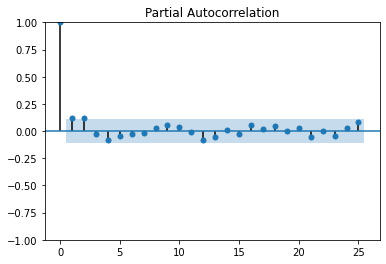

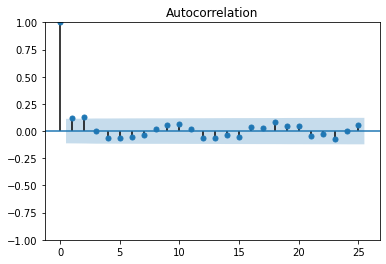

In [47]:
# https://vitalflux.com/autoregressive-ar-models-with-python-examples/
# https://www.youtube.com/watch?v=lPvIkGZjbZk

# Load AutoReg class from statsmodels.tsa.ar_model module
#
from statsmodels.tsa.ar_model import AutoReg

# find the order of AR model to be trained
# for this, we will plot partial autocorrelation plot to assess
# the direct effect of past data on future data

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

pacf = plot_pacf(gdp_df['Gross domestic product'], lags=25)
acf = plot_acf(gdp_df['Gross domestic product'], lags=25)

In [48]:
# Specify size of training set

num_gdp_timepoints = len(gdp_df)
gdp_training_size = int(num_gdp_timepoints * 0.99)
gdp_training = gdp_df[:gdp_training_size]
gdp_testing = gdp_df[gdp_training_size:]

print(f"Total number of GDP Timepoints: {num_gdp_timepoints}")
print(f"Training Timepoints: {gdp_training_size}")
print(f"Testing Timepoints: {len(gdp_df) - gdp_training_size}")

# Predict 4 quarters in advance

Total number of GDP Timepoints: 303
Training Timepoints: 299
Testing Timepoints: 4


### Autoregressive Model

In [49]:
# https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoReg.html

gdp_ra_model = AutoReg(gdp_training['Gross domestic product'], lags=10).fit()

# P value for each "L.1, L.2 .." indicates whether corresponding lag statistically
# significant when predicting current data. For quarterly GDP Data, very few lags are 
# significant

print(gdp_ra_model.summary()) 

                              AutoReg Model Results                               
Dep. Variable:     Gross domestic product   No. Observations:                  299
Model:                        AutoReg(10)   Log Likelihood                -848.886
Method:                   Conditional MLE   S.D. of innovations              4.565
Date:                    Sat, 18 Feb 2023   AIC                           1721.772
Time:                            17:43:10   BIC                           1765.769
Sample:                                10   HQIC                          1739.401
                                      299                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                          2.6320      0.589      4.469      0.000       1.478       3.786
Gross domestic product.L1      0.0906      0.059   

In [50]:
# make predictions

gdp_ra_preds = gdp_ra_model.predict(start = len(gdp_training), end = len(gdp_df) -1, dynamic = False)

In [57]:
# gdp_testing

In [58]:
np.sqrt(mse(gdp_df['Gross domestic product'][299: ], gdp_ra_preds))

4.54016286159339

### Moving Average Model

In [59]:
# https://www.kaggle.com/code/carlmcbrideellis/time-series-a-simple-moving-average-ma-model

from statsmodels.tsa.arima.model import ARIMA

gdp_ma_model = ARIMA(endog=gdp_training['Gross domestic product'], order=(0, 0, 10))

gdp_ma_results = gdp_ma_model.fit()
print(gdp_ma_results.summary())

                                 SARIMAX Results                                  
Dep. Variable:     Gross domestic product   No. Observations:                  299
Model:                    ARIMA(0, 0, 10)   Log Likelihood                -876.388
Date:                    Sat, 18 Feb 2023   AIC                           1776.777
Time:                            17:46:48   BIC                           1821.182
Sample:                                 0   HQIC                          1794.550
                                    - 299                                         
Covariance Type:                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2031      0.399      8.027      0.000       2.421       3.985
ma.L1          0.0971      0.032      3.077      0.002       0.035       0.159
ma.L2          0.152

In [60]:
gdp_ma_preds = gdp_ma_results.predict(start = len(gdp_training), end = len(gdp_df) -1)

In [61]:
np.sqrt(mse(gdp_df['Gross domestic product'][299: ], gdp_ma_preds))

5.915709698384523

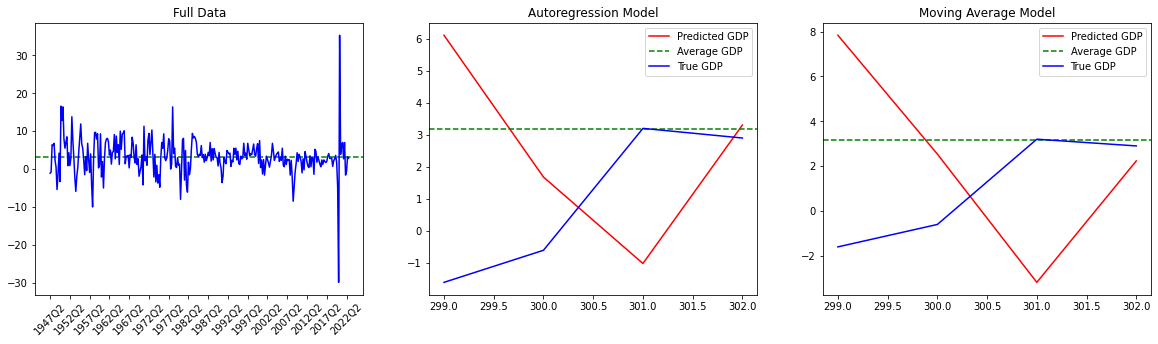

In [62]:
gdp_years = list(gdp_df['Year'])
testing_gdp_years = list(gdp_testing['Year'])

fig, ax = plt.subplots(1, 3, figsize = (20, 5))

# ax[0].plot(gdp_ra_preds, color='red', label = 'Predicted GDP')
ax[0].axhline(gdp_df['Gross domestic product'].mean(), color='green', linestyle='--', label = 'Average GDP')
ax[0].plot(gdp_df['Year'], gdp_df['Gross domestic product'], color = 'blue', )
ax[0].set_xticks(gdp_years[::20])
ax[0].set_xticklabels(gdp_years[::20], rotation=45)
ax[0].set_title("Full Data")

ax[1].plot(gdp_ra_preds, color='red', label = 'Predicted GDP')
ax[1].axhline(gdp_df['Gross domestic product'].mean(), color='green', linestyle='--',  label = 'Average GDP')
ax[1].plot(gdp_testing['Gross domestic product'], color = 'blue', label='True GDP')
# ax[1].set_xticks(testing_gdp_years[::2])
# ax[1].set_xticklabels(testing_gdp_years[::2], rotation=45)
ax[1].set_title("Autoregression Model")
ax[1].legend()

ax[2].plot(gdp_ma_preds, color='red', label = 'Predicted GDP')
ax[2].axhline(gdp_df['Gross domestic product'].mean(), color='green', linestyle='--', label = 'Average GDP')
ax[2].plot(gdp_testing['Gross domestic product'], color = 'blue', label = 'True GDP')
# ax[1].set_xticks(testing_gdp_years[::2])
# ax[1].set_xticklabels(testing_gdp_years[::2], rotation=45)
ax[2].set_title("Moving Average Model")
ax[2].legend()

plt.savefig('ma_gdp.png')
plt.show()

## Consumer Price Index

### Evaluate Autocorrelation of Dependent Variable

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


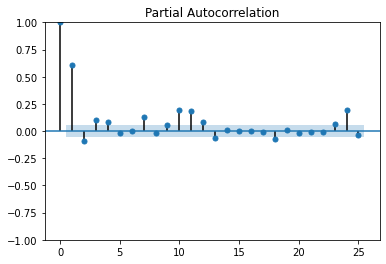

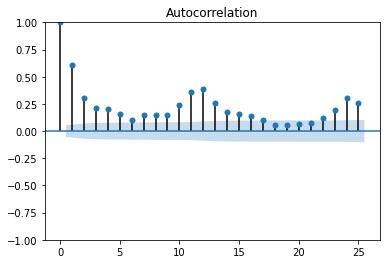

In [63]:
pacf = plot_pacf(cpi_df['Change'], lags=25)
acf = plot_acf(cpi_df['Change'], lags=25)

In [64]:
cpi_df['Change_2'] = cpi_df['CPI'].diff().diff()

/usr/local/lib/python3.8/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


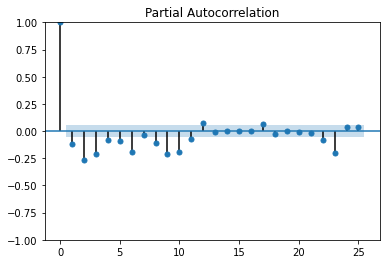

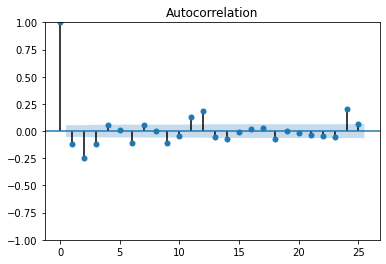

In [65]:

pacf = plot_pacf(cpi_df['Change_2'][2:], lags=25)
acf = plot_acf(cpi_df['Change_2'][2:], lags=25)

In [66]:
# specify size of training data

num_cpi_timepoints = len(cpi_df)
cpi_training_size = int(num_cpi_timepoints * 0.99)
cpi_training = cpi_df[:cpi_training_size]
cpi_testing = cpi_df[cpi_training_size:]

print(f"Total number of CPI Timepoints: {num_cpi_timepoints}")
print(f"Training Timepoints: {cpi_training_size}")
print(f"Testing Timepoints: {len(cpi_df) - cpi_training_size}")

# Predict up to 14 months in advance

Total number of CPI Timepoints: 1319
Training Timepoints: 1305
Testing Timepoints: 14


In [67]:
cpi_training = cpi_df[:len(cpi_df) - 19]
cpi_testing = cpi_df[len(cpi_df) - 19:]

It should be noted that for this particular analysis the Consumer Price Index data did not satisfy the assumptions (stationarity) for Autoregressive Time Series Modeling, although we have modeled the data here out of interest.

In [68]:
# initialize model with specified number of lags
cpi_ra_model = AutoReg(cpi_training['Change'], lags=15).fit()

print(cpi_ra_model.summary()) 

                            AutoReg Model Results                             
Dep. Variable:                 Change   No. Observations:                 1300
Model:                    AutoReg(15)   Log Likelihood                -409.660
Method:               Conditional MLE   S.D. of innovations              0.333
Date:                Sat, 18 Feb 2023   AIC                            853.321
Time:                        17:47:58   BIC                            941.015
Sample:                            15   HQIC                           886.243
                                 1300                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0386      0.013      3.034      0.002       0.014       0.064
Change.L1      0.5964      0.028     21.371      0.000       0.542       0.651
Change.L2     -0.1438      0.033     -4.418      0.0

In [69]:
# make predictions

cpi_ra_preds = cpi_ra_model.predict(start = len(cpi_training), end = len(cpi_df) -1, dynamic = False)

In [70]:
np.sqrt(mse(cpi_df.Change[1300: ], cpi_ra_preds))

1.4125729369985802

### Moving Average Model

In [71]:
from statsmodels.tsa.arima.model import ARIMA

cpi_ma_model = ARIMA(endog=cpi_training['Change'], order=(0, 0, 15))

cpi_ma_results = cpi_ma_model.fit()
print(cpi_ma_results.summary())

                               SARIMAX Results                                
Dep. Variable:                 Change   No. Observations:                 1300
Model:                ARIMA(0, 0, 15)   Log Likelihood                -424.423
Date:                Sat, 18 Feb 2023   AIC                            882.845
Time:                        17:49:49   BIC                            970.738
Sample:                             0   HQIC                           915.823
                               - 1300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2028      0.028      7.328      0.000       0.149       0.257
ma.L1          0.6248      0.016     37.946      0.000       0.593       0.657
ma.L2          0.2665      0.019     14.331      0.0

In [72]:
# make predictions

cpi_ma_preds = cpi_ma_results.predict(start = len(cpi_training), end = len(cpi_df) -1)

In [73]:
np.sqrt(mse(cpi_df.Change[1300: ], cpi_ma_preds))

1.5389293754313367

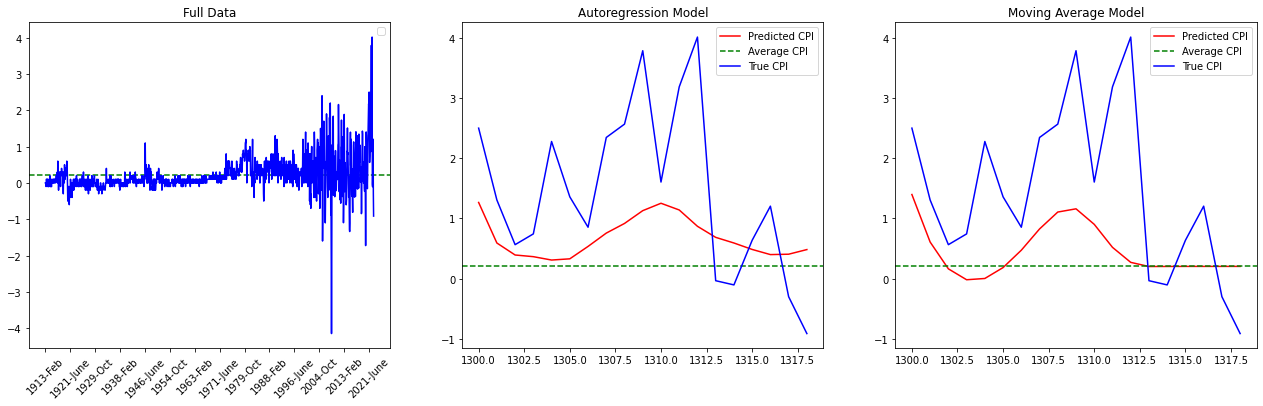

In [74]:
cpi_years = list(cpi_df['TimeStamp'])
# testing_gdp_years = list(gdp_testing['Year'])

fig, ax = plt.subplots(1, 3, figsize = (22, 6))

ax[0].axhline(cpi_df['Change'].mean(), color='green', linestyle='--')
ax[0].plot(cpi_df['TimeStamp'], cpi_df['Change'], color = 'blue')
ax[0].set_xticks(cpi_years[::100])
ax[0].set_xticklabels(cpi_years[::100], rotation=45)
ax[0].legend()
ax[0].set_title("Full Data")

ax[1].plot(cpi_ra_preds, color='red', label = 'Predicted CPI')
ax[1].axhline(cpi_df['Change'].mean(), color='green', linestyle='--', label = 'Average CPI')
ax[1].plot(cpi_testing['Change'], color = 'blue', label = 'True CPI')
# ax[1].set_xticks(testing_gdp_years[::2])
# ax[1].set_xticklabels(testing_gdp_years[::2], rotation=45)
ax[1].legend()
ax[1].set_title("Autoregression Model")

ax[2].plot(cpi_ma_preds, color='red', label = 'Predicted CPI')
ax[2].axhline(cpi_df['Change'].mean(), color='green', linestyle='--', label = 'Average CPI')
ax[2].plot(cpi_testing['Change'], color = 'blue', label='True CPI')
# ax[1].set_xticks(testing_gdp_years[::2])
# ax[1].set_xticklabels(testing_gdp_years[::2], rotation=45)
ax[2].set_title("Moving Average Model")
ax[2].legend()

plt.savefig("cpi_2.png")

plt.show()

## ARMA Grid Search Optimal Parameters

In [75]:
# https://betterprogramming.pub/using-auto-arima-with-python-e482e322f430

model = auto_arima(cpi_training['Change'], start_p=0, start_q=0)

print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1300
Model:               SARIMAX(2, 1, 2)   Log Likelihood                -447.922
Date:                Sat, 18 Feb 2023   AIC                            905.844
Time:                        17:51:28   BIC                            931.691
Sample:                             0   HQIC                           915.542
                               - 1300                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1152      0.053     20.976      0.000       1.011       1.219
ar.L2         -0.4491      0.029    -15.669      0.000      -0.505      -0.393
ma.L1         -1.5282      0.056    -27.303      0.0

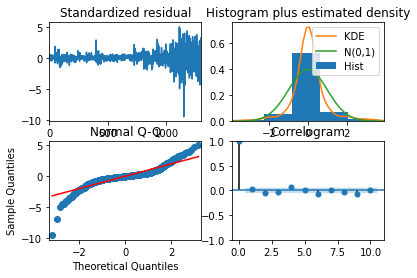

In [76]:
model.plot_diagnostics()
plt.show()

## ARCH Model

In [78]:
#!pip install arch

from arch import arch_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 907.3/907.3 KB 15.3 MB/s eta 0:00:00


In [81]:
# define model
arch_cpi_model = arch_model(cpi_training['Change'], mean='Zero', vol='ARCH', p=4, q=4)

arch_cpi_model_fit = arch_cpi_model.fit()
# forecast the test set
arch_cpi_preds = arch_cpi_model_fit.forecast(horizon=len(cpi_testing))

Iteration:      1,   Func. Count:      7,   Neg. LLF: 136485.86906788655
Iteration:      2,   Func. Count:     14,   Neg. LLF: 9611.655551277327
Iteration:      3,   Func. Count:     21,   Neg. LLF: 58868532.22520791
Iteration:      4,   Func. Count:     28,   Neg. LLF: 37872611.13076444
Iteration:      5,   Func. Count:     35,   Neg. LLF: 109044.54064362758
Iteration:      6,   Func. Count:     42,   Neg. LLF: 22969065.098866973
Iteration:      7,   Func. Count:     49,   Neg. LLF: 35304465.062087156
Iteration:      8,   Func. Count:     56,   Neg. LLF: 37872624.45756375
Iteration:      9,   Func. Count:     63,   Neg. LLF: 27292799.286611214
Iteration:     10,   Func. Count:     70,   Neg. LLF: 35304669.195860505
Iteration:     11,   Func. Count:     77,   Neg. LLF: 151.0500531224556
Iteration:     12,   Func. Count:     84,   Neg. LLF: 148.48396699869136
Iteration:     13,   Func. Count:     91,   Neg. LLF: 126.57673615372573
Iteration:     14,   Func. Count:     97,   Neg. LLF: 12

/usr/local/lib/python3.8/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


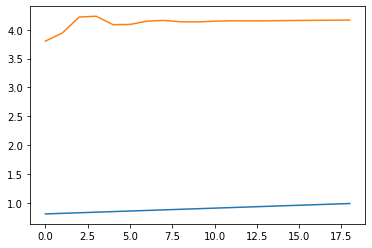

In [80]:
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-len(cpi_testing):])

# plot forecast variance
plt.plot(arch_cpi_preds.variance.values[-1, :])
plt.show()

In [ ]:
# define model
arch_cpi_model_2 = arch_model(cpi_training['Change_2'][2:], mean='Zero', vol='ARCH', p=15)

arch_cpi_model_fit_2 = arch_cpi_model_2.fit()
# forecast the test set
arch_cpi_preds_2 = arch_cpi_model_fit_2.forecast(horizon=len(cpi_testing))

Iteration:      1,   Func. Count:     18,   Neg. LLF: 224124.65379516367
Iteration:      2,   Func. Count:     36,   Neg. LLF: 55846332.201235086
Iteration:      3,   Func. Count:     54,   Neg. LLF: 14974.795783824966
Iteration:      4,   Func. Count:     72,   Neg. LLF: 3964.783245130919
Iteration:      5,   Func. Count:     90,   Neg. LLF: 413007.23916019395
Iteration:      6,   Func. Count:    108,   Neg. LLF: 115304.7475311113
Iteration:      7,   Func. Count:    126,   Neg. LLF: 151076.45644360362
Iteration:      8,   Func. Count:    144,   Neg. LLF: 2127445.302484843
Iteration:      9,   Func. Count:    162,   Neg. LLF: 2692532.340316559
Iteration:     10,   Func. Count:    180,   Neg. LLF: 4149688.7618783987
Iteration:     11,   Func. Count:    198,   Neg. LLF: 752552.1991818269
Iteration:     12,   Func. Count:    216,   Neg. LLF: 1145946.1813682467
Iteration:     13,   Func. Count:    234,   Neg. LLF: 54.5269888701381
Iteration:     14,   Func. Count:    252,   Neg. LLF: -16.

/usr/local/lib/python3.8/dist-packages/arch/__future__/_utility.py:11: FutureWarning: 
The default for reindex is True. After September 2021 this will change to
False. Set reindex to True or False to silence this message. Alternatively,
you can use the import comment

from arch.__future__ import reindexing

to globally set reindex to True and silence this warning.

  warnings.warn(


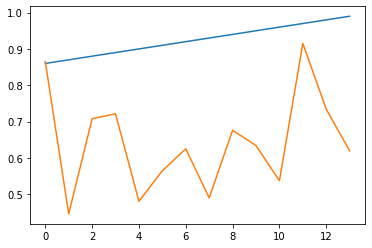

In [ ]:
var = [i*0.01 for i in range(0,100)]
plt.plot(var[-len(cpi_testing):])

# plot forecast variance
plt.plot(arch_cpi_preds_2.variance.values[-1, :])
plt.show()

In [ ]:
import seaborn as sns

In [ ]:
sns

<module 'seaborn' from '/usr/local/lib/python3.8/dist-packages/seaborn/__init__.py'>

# LSTM for time series forecasting (using Keras)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
cpi_scaler = MinMaxScaler()
gdp_scaler = MinMaxScaler()

from keras.preprocessing.sequence import TimeseriesGenerator

from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM

In [ ]:
cpi_train = np.array(cpi_df.Change[ : 1300]).reshape(-1,1)
cpi_test = np.array(cpi_df.Change[1300: ]).reshape(-1,1)

In [ ]:
# train = np.array(cpi_df.CPI[ : 1300]).reshape(-1,1)
# test = np.array(cpi_df.CPI[1300: ]).reshape(-1,1)

In [ ]:
gdp_training.columns

Index(['Year', 'Gross domestic product', 'Personal consumption expenditures',
       'Goods', 'Durable goods', 'Nondurable goods', 'Services',
       'Gross private domestic investment', 'Fixed investment',
       'Nonresidential', 'Structures', 'Equipment',
       'Intellectual property products', 'Residential',
       'Change in private inventories', 'Net exports of goods and services',
       'Exports', 'Goods.1', 'Services.1', 'Imports', 'Goods.2', 'Services.2',
       'Government consumption expenditures and gross investment', 'Federal',
       'National defense', 'Nondefense', 'State and local', 'CPI'],
      dtype='object')

In [ ]:
#train - test split for gdp data
gdp_train = np.array(gdp_training['Gross domestic product']).reshape(-1,1)
gdp_test = np.array(gdp_testing['Gross domestic product']).reshape(-1,1)


In [ ]:
cpi_scaler.fit(cpi_train)
cpi_train_scaled = cpi_scaler.transform(cpi_train)
cpi_test_scaled = cpi_scaler.transform(cpi_test)

In [ ]:
gdp_scaler.fit(gdp_train)
gdp_train_scaled = gdp_scaler.transform(gdp_train)
gdp_test_scaled = gdp_scaler.transform(gdp_test)

In [ ]:
n_input = 12
n_features = 1
cpi_generator = TimeseriesGenerator(cpi_train_scaled, cpi_train_scaled, length = n_input, batch_size = 1)
gdp_generator = TimeseriesGenerator(gdp_train_scaled, gdp_train_scaled, length = 3, batch_size = 1)

In [ ]:
len(cpi_train_scaled), len(cpi_generator)

(1300, 1288)

In [ ]:
len(gdp_train_scaled), len(gdp_generator)

(299, 296)

In [ ]:
cpi_LSTM_model = Sequential()
cpi_LSTM_model.add(LSTM(100, activation = 'relu', input_shape = (n_input, n_features)))
cpi_LSTM_model.add(Dense(1))
cpi_LSTM_model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
gdp_LSTM_model = Sequential()
gdp_LSTM_model.add(LSTM(100, activation = 'relu', input_shape = (3, n_features)))
gdp_LSTM_model.add(Dense(1))
gdp_LSTM_model.compile(optimizer = 'adam', loss = 'mse')

In [ ]:
cpi_LSTM_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100)               40800     
                                                                 
 dense (Dense)               (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
gdp_LSTM_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               40800     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cpi_LSTM_model.fit(cpi_generator, epochs = 50)

Epoch 1/50
1288/1288 [==============================] - 33s 26ms/step - loss: 0.0044
Epoch 2/50
1288/1288 [==============================] - 39s 30ms/step - loss: 0.0041
Epoch 3/50
1288/1288 [==============================] - 36s 28ms/step - loss: 0.0038
Epoch 4/50
1288/1288 [==============================] - 34s 27ms/step - loss: 0.0035
Epoch 5/50
1288/1288 [==============================] - 35s 27ms/step - loss: 0.0034
Epoch 6/50
1288/1288 [==============================] - 33s 25ms/step - loss: 0.0033
Epoch 7/50
1288/1288 [==============================] - 34s 26ms/step - loss: 0.0031
Epoch 8/50
1288/1288 [==============================] - 33s 26ms/step - loss: 0.0032
Epoch 9/50
1288/1288 [==============================] - 32s 25ms/step - loss: 0.0032
Epoch 10/50
1288/1288 [==============================] - 35s 27ms/step - loss: 0.0032
Epoch 11/50
1288/1288 [==============================] - 33s 26ms/step - loss: 0.0031
Epoch 12/50
1288/1288 [==============================] - 35s 27

In [ ]:
gdp_LSTM_model.fit(gdp_generator, epochs = 50)

Epoch 1/50
296/296 [==============================] - 8s 8ms/step - loss: 0.0212
Epoch 2/50
296/296 [==============================] - 3s 8ms/step - loss: 0.0057
Epoch 3/50
296/296 [==============================] - 3s 10ms/step - loss: 0.0056
Epoch 4/50
296/296 [==============================] - 6s 19ms/step - loss: 0.0058
Epoch 5/50
296/296 [==============================] - 4s 12ms/step - loss: 0.0055
Epoch 6/50
296/296 [==============================] - 4s 15ms/step - loss: 0.0059
Epoch 7/50
296/296 [==============================] - 8s 26ms/step - loss: 0.0054
Epoch 8/50
296/296 [==============================] - 5s 16ms/step - loss: 0.0056
Epoch 9/50
296/296 [==============================] - 2s 8ms/step - loss: 0.0053
Epoch 10/50
296/296 [==============================] - 6s 19ms/step - loss: 0.0054
Epoch 11/50
296/296 [==============================] - 3s 10ms/step - loss: 0.0054
Epoch 12/50
296/296 [==============================] - 5s 16ms/step - loss: 0.0055
Epoch 13/50
296/

In [ ]:
loss_per_epoch_cpi = cpi_LSTM_model.history.history['loss']
loss_per_epoch_gdp = gdp_LSTM_model.history.history['loss']

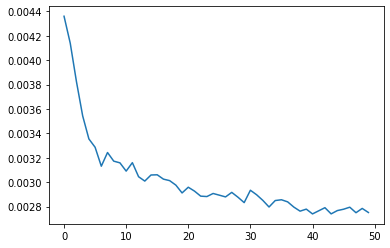

In [ ]:
plt.plot(range(len(loss_per_epoch_cpi)), loss_per_epoch_cpi)

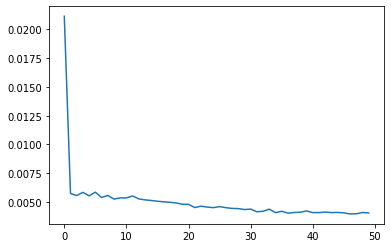

In [ ]:
plt.plot(range(len(loss_per_epoch_gdp)), loss_per_epoch_gdp)

In [ ]:
cpi_last_batch = cpi_train_scaled[-n_input: ].reshape((1, n_input, n_features))
gdp_last_batch = gdp_train_scaled[-3: ].reshape((1, 3, n_features))

In [ ]:
cpi_LSTM_model.predict(cpi_last_batch)

1/1 [==============================] - 0s 269ms/step


array([[0.8215854]], dtype=float32)

In [ ]:
cpi_test_scaled[0]

array([1.01542456])

In [ ]:
gdp_LSTM_model.predict(gdp_last_batch)

1/1 [==============================] - 0s 177ms/step


array([[0.5111679]], dtype=float32)

In [ ]:
gdp_test_scaled[0]

array([0.43404908])

In [ ]:
cpi_predictions = []
cpi_test_batch = cpi_train_scaled[-n_input: ].reshape((1, n_input, n_features))
for idx in range(len(cpi_test_scaled)):
  pred = cpi_LSTM_model.predict(cpi_test_batch)[0]
  cpi_predictions.append(pred)
  cpi_test_batch = np.append(cpi_test_batch[ : , 1: , : ], [[pred]] , axis = 1)


1/1 [==============================] - 0s 23ms/step


In [ ]:
gdp_predictions = []
gdp_test_batch = gdp_train_scaled[-3: ].reshape((1, 3, n_features))
for idx in range(len(gdp_test_scaled)):
  pred = gdp_LSTM_model.predict(gdp_test_batch)[0]
  gdp_predictions.append(pred)
  gdp_test_batch = np.append(gdp_test_batch[ : , 1: , : ], [[pred]] , axis = 1)

1/1 [==============================] - 0s 98ms/step


In [ ]:
cpi_model_predictions = cpi_scaler.inverse_transform(cpi_predictions)
gdp_model_predictions = gdp_scaler.inverse_transform(gdp_predictions)

In [ ]:
len(cpi_model_predictions), len(cpi_test)

(19, 19)

In [ ]:
cpi_predictions_df = pd.DataFrame(data=np.column_stack((cpi_test,cpi_model_predictions)),columns=['actual','predicted'])
gdp_predictions_df = pd.DataFrame(data=np.column_stack((gdp_test,gdp_model_predictions)),columns=['actual','predicted'])

In [ ]:
cpi_testing

NameError: ignored

<Figure size 1500x1200 with 0 Axes>

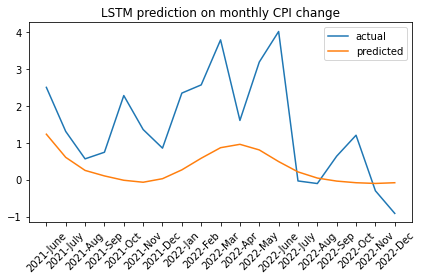

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(15, 12), dpi=100)
cpi_predictions_df.plot()
plt.title("LSTM prediction on monthly CPI change")
plt.xticks([i for i in range(19)], rotation = 45, labels = list(cpi_testing['TimeStamp']))
# ax[1].set_xticklabels(testing_gdp_years[::2], rotation=45)
plt.tight_layout()

plt.savefig("cpi_change.jpeg")
plt.show()

<Figure size 800x1200 with 0 Axes>

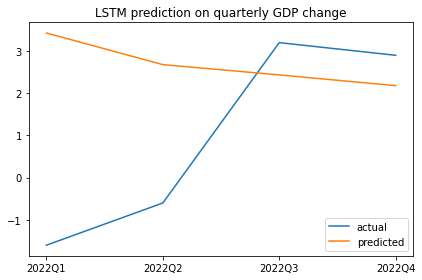

In [ ]:
figure(figsize=(8, 12), dpi=100)
gdp_predictions_df.plot()
plt.title("LSTM prediction on quarterly GDP change")
plt.xticks([i for i in range(4)], rotation = 0, labels = list(gdp_testing['Year']))
plt.tight_layout()
plt.savefig("GDP_change.jpeg")

In [ ]:
#cpi_predictions_df

In [ ]:
from sklearn.metrics import mean_squared_error as mse
print("The error on the test set for CPI data: ", np.sqrt(mse(cpi_predictions_df.actual, cpi_predictions_df.predicted)))
print("The error on the test set for GDP data: ", np.sqrt(mse(gdp_predictions_df.actual, gdp_predictions_df.predicted)))

The error on the test set for CPI data:  1.6036221922774783
The error on the test set for GDP data:  3.046996241406421


# FB Prophet

In [6]:
#Uncomment this block of code if you don't have prophet already installed 
#!pip3 install pystan==2.18.0.0
#!pip3 install fbprophet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.5/17.5 MB 73.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pystan: filename=pystan-2.18.0.0-cp38-cp38-linux_x86_64.whl size=60178576 sha256=b6b08d7bd9bd3d5f164ea61d44de3c11be2fdf1feef0859ab391cbc22802b204
  Stored in directory: /root/.cache/pip/wheels/c9/8d/a0/87147a86c11b867cb8e500fa47c9dd551624c336159f4a7b9f
Successfully built pystan
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.0/64.0 KB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fbprophet: filename=fbprophet-0.7.1-py3-none-any.whl size=8943812 sha256=18c805bca10f693

In [31]:
from fbprophet import Prophet
cpi_prophet_model = Prophet()
gdp_prophet_model = Prophet()

In [32]:
cpi_for_prophet = pd.DataFrame({'ds': cpi_df.TimeStamp, 'y': cpi_df.Change})
gdp_for_prophet = pd.DataFrame({'ds': gdp_df.Year, 'y': gdp_df['Gross domestic product']})

In [33]:
cpi_prophet_model.fit(cpi_for_prophet.iloc[: 1300])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
gdp_prophet_model.fit(gdp_for_prophet.iloc[: 299])

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [35]:
cpi_forecast = cpi_prophet_model.predict(cpi_for_prophet.iloc[1300: ])

In [36]:
cpi_prophet_forecast = cpi_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [37]:
gdp_forecast = gdp_prophet_model.predict(gdp_for_prophet.iloc[299: ])
gdp_prophet_forecast = gdp_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

In [38]:
cpi_prophet_forecast.head()

,ds,yhat,yhat_lower,yhat_upper
0,2021-06-01,0.497618,0.008061,0.973058
1,2021-07-01,0.380185,-0.113001,0.840382
2,2021-08-01,0.391913,-0.135434,0.884279
3,2021-09-01,0.470497,-0.019695,0.954203
4,2021-10-01,0.335109,-0.173342,0.843418


In [39]:
gdp_prophet_forecast.head()

,ds,yhat,yhat_lower,yhat_upper
0,2022-01-01,2.172665,-4.011784,8.126104
1,2022-04-01,2.014166,-3.466294,8.089058
2,2022-07-01,2.626723,-2.918853,8.352950
3,2022-10-01,1.700666,-4.272404,7.710174


In [40]:
cpi_prophet_predictions_df = pd.DataFrame(data=np.column_stack((cpi_for_prophet.y.iloc[1300: ], 
                                                            cpi_prophet_forecast.yhat)),
                                      columns=['actual','predicted'])

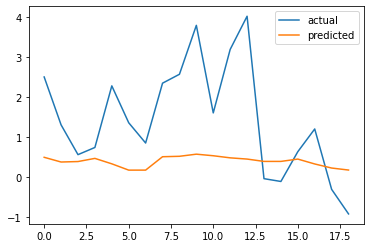

In [41]:
cpi_prophet_predictions_df.plot()

In [42]:
gdp_prophet_predictions_df = pd.DataFrame(data=np.column_stack((gdp_for_prophet.y.iloc[299: ], 
                                                            gdp_prophet_forecast.yhat)),
                                      columns=['actual','predicted'])

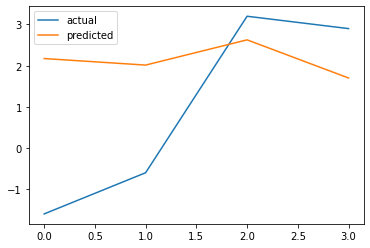

In [43]:
gdp_prophet_predictions_df.plot()

In [44]:
print("The error on the test set for CPI data: ", np.sqrt(mse(cpi_prophet_predictions_df.actual, cpi_prophet_predictions_df.predicted)))
print("The error on the test set for GDP data: ", np.sqrt(mse(gdp_prophet_predictions_df.actual, gdp_prophet_predictions_df.predicted)))

The error on the test set for CPI data:  1.6592995657205396
The error on the test set for GDP data:  2.389242172302086


## Old Code

In [ ]:
# gdp_df_temp = gdp_df[['Year', 'Gross domestic product']]
# gdp_df_temp['Lag1'] = gdp_df['Gross domestic product'].shift(1) # GDP 1 quarter before
# gdp_df_temp['Lag2'] = gdp_df['Gross domestic product'].shift(2) # GDP 2 quarters before
# gdp_df_temp['Lag3'] = gdp_df['Gross domestic product'].shift(3) # GDP 3 quarters before
# gdp_df_temp['Spending on cars'] = 123
# gdp_df_temp['Unemployment Rate'] = 0.05
# gdp_df_temp['President Poltical Party'] = 'Republican'

In [ ]:
# gdp_df_temp.head()

In [ ]:
# Gross Domomestic Product is Good - we want GDP to be roughly 2%
# if too high, can lead to inflation
# if negative, can lead to recession

In [ ]:
# For ML - we can only predict a single value (the GDP or CPI of a specific Quarter)
# If we want to get for additional quarters, we have to train a new model with our 
# target variable as the new quarter

# For time series, we can predict as far out (and for as many quarters) as we want
# But we only use time and previous GDP data for the models